# Ridge Regression (interpretation)

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
* Use a pre-built implementation of regression (sklearn) to run polynomial regression
* Use matplotlib to visualize polynomial regressions
* Use a pre-built implementation of regression (sklearn) to run polynomial regression, this time with L2 penalty
* Use matplotlib to visualize polynomial regressions under L2 regularization
* Choose best L2 penalty using cross-validation.
* Assess the final fit using test data.

We will continue to use the House data.

In [6]:
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split, KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

# Polynomial Regression - revisited

Function to produce an DataFrame with columns containing the powers of a given input. 

In [7]:
def polynomial_dframe(feature, degree):
    # assume that degree >= 1
    # initialize the Data Frame:
    poly_dframe = pd.DataFrame()
    
    # and set poly_dframe['power_1'] equal to the passed feature
    poly_dframe['power_1'] = feature
    
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_dframe[name] to the appropriate power of feature
            
            def powered(x):
                return math.pow(x, power)
            powered = np.vectorize(powered)
            poly_dframe[name] = powered(feature)
            #poly_dframe[name] = feature.apply(lambda x: x**power)
    #print poly_dframe.head()

    return poly_dframe

Let's use matplotlib to visualize what a polynomial regression looks like on the house data.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
sales = pd.read_csv('data/kc_housing_sales_data.csv')
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


We will continue using the sqft_living variable. For plotting purposes (connecting the dots), we'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [10]:
sales = sales.sort_values(['sqft_living','price'])

In [11]:
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
19452,3980300371,20140926T000000,142000,0,0.00,290,20875,1,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
15381,2856101479,20140701T000000,276000,1,0.75,370,1801,1,0,0,...,5,370,0,1923,0,98117,47.6778,-122.389,1340,5000
860,1723049033,20140620T000000,245000,1,0.75,380,15000,1,0,0,...,5,380,0,1963,0,98168,47.4810,-122.323,1170,15000
18379,1222029077,20141029T000000,265000,0,0.75,384,213444,1,0,0,...,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
4868,6896300380,20141002T000000,228000,0,1.00,390,5900,1,0,0,...,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000


In [12]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coef_)

    # Get learned parameters as a list
    w = [model.intercept_] + model.coef_.tolist()
    
    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print 'Learned polynomial for degree ' + str(deg) + ':'
    
    w.reverse()
    
    print np.poly1d(w)

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_dframe()` and fit a model with these features. When fitting the model, use an L2 penalty of `1e-5`:

In [13]:
l2_small_penalty = 1e-5

**Note:** When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  (The regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, fit the model and print out the learned weights.

In [14]:
for degree in range(15,16):
    poly_data_dframe = polynomial_dframe(sales['sqft_living'],degree)
        
    my_features = poly_data_dframe.columns.tolist()
    print my_features
    
    X = poly_data_dframe[my_features]
    poly_data_dframe['price'] = sales['price']
    y = poly_data_dframe['price']
    
    model = Ridge(alpha=l2_small_penalty)
    model.fit(X, y)

    print_coefficients(model)

['power_1', 'power_2', 'power_3', 'power_4', 'power_5', 'power_6', 'power_7', 'power_8', 'power_9', 'power_10', 'power_11', 'power_12', 'power_13', 'power_14', 'power_15']
Learned polynomial for degree 15:
            15             14             13             12
-3.498e-49 x  - 1.313e-43 x  + 1.135e-38 x  - 3.521e-34 x 
              11             10             9             8
 + 5.336e-30 x  - 4.081e-26 x  + 1.273e-22 x + 9.095e-20 x
              7             6             5             4             3
 - 9.829e-16 x - 3.839e-20 x - 5.507e-20 x - 4.947e-25 x - 1.615e-30 x
              2
 + 9.072e-36 x + 1.577e+04 x + 2.208e+08


# Observe overfitting

Recall from [Assessing Fit (polynomial regression)](https://github.com/ranjankumar-gh/ml-specialization/blob/master/regression/notebooks/4-assessing-fit-polynomial-regression.ipynb) that the polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the sales data into four subsets and fit the model of degree 15, the result came out to be very different for each subset. The model had a *high variance*. We will see in a moment that **ridge regression reduces such variance**. But first, we must reproduce the experiment we did.

First, split the data into split the sales data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. Use `.random_split` function and make sure you set `seed=0`. 

In [15]:
(sales1, sales2) = train_test_split(sales, test_size = 0.5, train_size = 0.5, random_state = 1)
(set_1, set_2) = train_test_split(sales1, test_size = 0.5, train_size = 0.5, random_state = 1)
(set_3, set_4) = train_test_split(sales2, test_size = 0.5, train_size = 0.5, random_state = 1)
set_1 = set_1.sort_values(['sqft_living'])
set_2 = set_2.sort_values(['sqft_living'])
set_3 = set_3.sort_values(['sqft_living'])
set_4 = set_4.sort_values(['sqft_living'])

Next, fit a 15th degree polynomial on `set_1`, `set_2`, `set_3`, and `set_4`, using 'sqft_living' to predict prices. Print the weights and make a plot of the resulting model.

Hint: When creating ridge model, use the same L2 penalty as before (i.e. `l2_small_penalty`).

## Set 1

In [16]:
degree = 15

poly15_data_set_1 = polynomial_dframe(set_1['sqft_living'],degree)
my_features = poly15_data_set_1.columns.tolist()

X15_set_1 = poly15_data_set_1[my_features]
poly15_data_set_1['price'] = set_1['price']
y15_set_1 = poly15_data_set_1['price']

model15_set_1 = Ridge(alpha=l2_small_penalty)
model15_set_1.fit(X15_set_1, y15_set_1)

print_coefficients(model15_set_1)

Learned polynomial for degree 15:
            15             14             13             12
-1.312e-47 x  + 8.892e-43 x  - 2.516e-38 x  + 3.869e-34 x 
              11             10             9             8
 - 3.479e-30 x  + 1.775e-26 x  - 4.164e-23 x - 5.428e-21 x
              7             6             5             4             3
 + 1.521e-16 x + 1.963e-20 x - 6.087e-21 x - 1.406e-25 x + 2.572e-31 x
              2
 + 3.029e-36 x - 3.197e+05 x + 6.046e+08


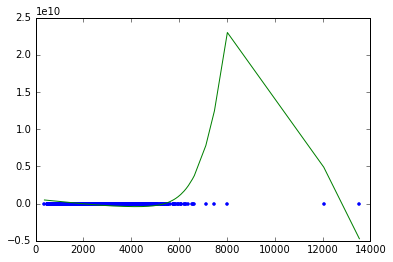

In [17]:
plt.plot(poly15_data_set_1['power_1'],poly15_data_set_1['price'],'.',
        poly15_data_set_1['power_1'], model15_set_1.predict(X15_set_1),'-')

## Set 2

In [18]:
degree = 15

poly15_data_set_2 = polynomial_dframe(set_2['sqft_living'],degree)
my_features = poly15_data_set_2.columns.tolist()

X15_set_2 = poly15_data_set_2[my_features]
poly15_data_set_2['price'] = set_2['price']
y15_set_2 = poly15_data_set_2['price']

model15_set_2 = Ridge(alpha=l2_small_penalty)
model15_set_2.fit(X15_set_2, y15_set_2)

print_coefficients(model15_set_2)

Learned polynomial for degree 15:
            15             14             13             12
-1.581e-46 x  + 8.846e-42 x  - 2.099e-37 x  + 2.719e-33 x 
              11             10             9             8
 - 2.074e-29 x  + 9.336e-26 x  - 2.313e-22 x + 2.525e-19 x
              7             6             5             4             3
 - 3.163e-17 x - 3.776e-18 x + 3.636e-20 x - 1.934e-24 x - 1.312e-29 x
              2
 + 4.334e-34 x - 2.381e+04 x + 4.273e+07


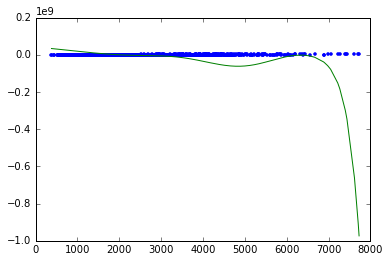

In [19]:
plt.plot(poly15_data_set_2['power_1'],poly15_data_set_2['price'],'.',
        poly15_data_set_2['power_1'], model15_set_2.predict(X15_set_2),'-')

## Set 3

In [20]:
degree = 15

poly15_data_set_3 = polynomial_dframe(set_3['sqft_living'],degree)
my_features = poly15_data_set_3.columns.tolist()

X15_set_3 = poly15_data_set_3[my_features]
poly15_data_set_3['price'] = set_3['price']
y15_set_3 = poly15_data_set_3['price']

model15_set_3 = Ridge(alpha=l2_small_penalty)
model15_set_3.fit(X15_set_3, y15_set_3)

print_coefficients(model15_set_3)

Learned polynomial for degree 15:
            15             14             13            12
-4.081e-46 x  + 3.036e-41 x  - 9.461e-37 x  + 1.61e-32 x 
              11             10             9             8
 - 1.626e-28 x  + 9.875e-25 x  - 3.441e-21 x + 5.929e-18 x
              7             6             5             4             3
 - 3.069e-15 x + 2.971e-18 x - 1.167e-20 x + 4.227e-24 x + 7.985e-29 x
              2
 - 3.698e-33 x - 1.737e+06 x + 2.979e+09


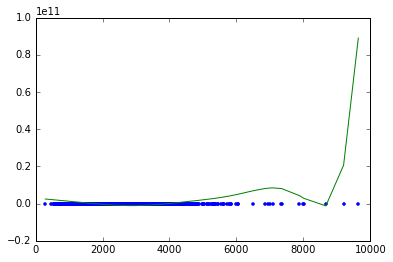

In [21]:
plt.plot(poly15_data_set_3['power_1'],poly15_data_set_3['price'],'.',
        poly15_data_set_3['power_1'], model15_set_3.predict(X15_set_3),'-')

## Set 4

In [22]:
degree = 15

poly15_data_set_4 = polynomial_dframe(set_4['sqft_living'],degree)
my_features = poly15_data_set_4.columns.tolist()

X15_set_4 = poly15_data_set_4[my_features]
poly15_data_set_4['price'] = set_4['price']
y15_set_4 = poly15_data_set_4['price']

model15_set_4 = Ridge(alpha=l2_small_penalty)
model15_set_4.fit(X15_set_4, y15_set_4)

print_coefficients(model15_set_4)

Learned polynomial for degree 15:
            15             14             13            12
-1.339e-46 x  + 7.074e-42 x  - 1.547e-37 x  + 1.83e-33 x 
              11             10             9            8
 - 1.264e-29 x  + 4.952e-26 x  - 8.585e-23 x - 5.46e-20 x
              7             6             5            4             3
 + 3.373e-16 x + 3.222e-19 x + 8.697e-20 x + 2.95e-24 x - 6.554e-29 x
              2
 + 4.576e-35 x - 1.412e+05 x + 2.274e+08


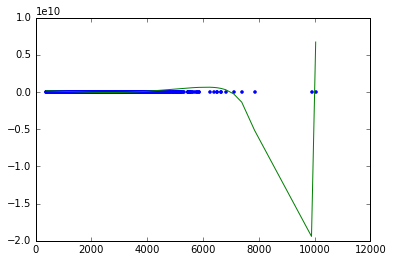

In [23]:
plt.plot(poly15_data_set_4['power_1'],poly15_data_set_4['price'],'.',
        poly15_data_set_4['power_1'], model15_set_4.predict(X15_set_4),'-')

The four curves should differ from one another a lot, as should the coefficients you learned.

# Ridge regression comes to rescue

**Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights.** (Weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

With the argument `l2_penalty=1e5`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty` parameter, the code should be the same as the experiment above.

In [24]:
l2_penalty=1e5

## Set 1

In [25]:
degree = 15

poly15_data_set_1 = polynomial_dframe(set_1['sqft_living'],degree)
my_features = poly15_data_set_1.columns.tolist()

X15_set_1 = poly15_data_set_1[my_features]
poly15_data_set_1['price'] = set_1['price']
y15_set_1 = poly15_data_set_1['price']

model15_set_1 = Ridge(alpha=l2_penalty)
model15_set_1.fit(X15_set_1, y15_set_1)

print_coefficients(model15_set_1)

Learned polynomial for degree 15:
            15             14             13            12
-4.279e-49 x  + 3.448e-44 x  - 1.299e-39 x  + 2.67e-35 x 
              11             10             9             8
 - 3.104e-31 x  + 2.033e-27 x  - 6.909e-24 x + 7.984e-21 x
              7            6             5             4             3
 + 7.467e-18 x - 8.63e-22 x + 8.838e-22 x + 2.641e-26 x - 1.975e-32 x
              2
 + 1.482e-37 x - 0.4021 x - 1.653e+06


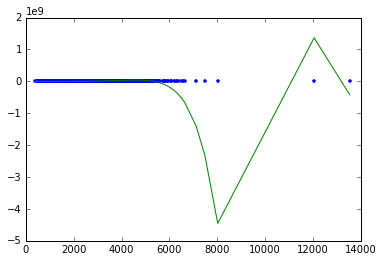

In [26]:
plt.plot(poly15_data_set_1['power_1'],poly15_data_set_1['price'],'.',
        poly15_data_set_1['power_1'], model15_set_1.predict(X15_set_1),'-')

## Set 2

In [27]:
degree = 15

poly15_data_set_2 = polynomial_dframe(set_2['sqft_living'],degree)
my_features = poly15_data_set_2.columns.tolist()

X15_set_2 = poly15_data_set_2[my_features]
poly15_data_set_2['price'] = set_2['price']
y15_set_2 = poly15_data_set_2['price']

model15_set_2 = Ridge(alpha=l2_penalty)
model15_set_2.fit(X15_set_2, y15_set_2)

print_coefficients(model15_set_2)

Learned polynomial for degree 15:
            15             14             13             12
-8.982e-47 x  + 3.901e-42 x  - 7.356e-38 x  + 7.782e-34 x 
              11             10             9             8
 - 4.971e-30 x  + 1.912e-26 x  - 4.081e-23 x + 3.649e-20 x
              7             6             5             4             3
 + 3.221e-18 x + 2.034e-19 x + 7.793e-24 x + 1.306e-26 x + 4.843e-30 x
              2
 - 1.132e-34 x - 0.3712 x - 1.851e+06


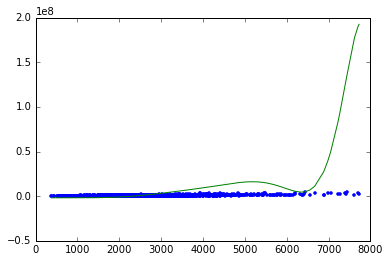

In [28]:
plt.plot(poly15_data_set_2['power_1'],poly15_data_set_2['price'],'.',
        poly15_data_set_2['power_1'], model15_set_2.predict(X15_set_2),'-')

## Set 3

In [29]:
degree = 15

poly15_data_set_3 = polynomial_dframe(set_3['sqft_living'],degree)
my_features = poly15_data_set_3.columns.tolist()

X15_set_3 = poly15_data_set_3[my_features]
poly15_data_set_3['price'] = set_3['price']
y15_set_3 = poly15_data_set_3['price']

model15_set_3 = Ridge(alpha=l2_penalty)
model15_set_3.fit(X15_set_3, y15_set_3)

print_coefficients(model15_set_3)

Learned polynomial for degree 15:
            15            14             13             12
-4.039e-47 x  + 1.87e-42 x  - 3.439e-38 x  + 2.942e-34 x 
             11             10             9            8             7
 - 7.01e-31 x  - 7.718e-27 x  + 7.076e-23 x - 2.32e-19 x + 2.816e-16 x
              6             5             4             3             2
 + 6.939e-20 x + 3.055e-21 x - 1.418e-26 x + 3.657e-31 x + 3.863e-35 x - 30.2 x - 4.813e+06


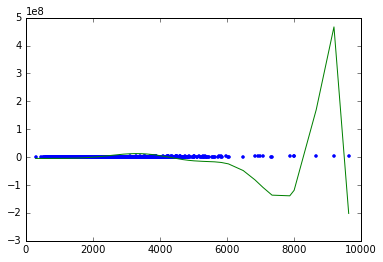

In [30]:
plt.plot(poly15_data_set_3['power_1'],poly15_data_set_3['price'],'.',
        poly15_data_set_3['power_1'], model15_set_3.predict(X15_set_3),'-')

## Set 4

In [31]:
degree = 15

poly15_data_set_4 = polynomial_dframe(set_4['sqft_living'],degree)
my_features = poly15_data_set_4.columns.tolist()

X15_set_4 = poly15_data_set_4[my_features]
poly15_data_set_4['price'] = set_4['price']
y15_set_4 = poly15_data_set_4['price']

model15_set_4 = Ridge(alpha=l2_penalty)
model15_set_4.fit(X15_set_4, y15_set_4)

print_coefficients(model15_set_4)

Learned polynomial for degree 15:
          15            14             13             12             11
-1.8e-47 x  + 1.01e-42 x  - 2.411e-38 x  + 3.183e-34 x  - 2.527e-30 x 
             10             9            8             7            6
 + 1.22e-26 x  - 3.383e-23 x + 4.54e-20 x - 1.642e-17 x - 1.19e-20 x
              5             4             3           2
 - 6.525e-21 x - 1.179e-25 x + 3.111e-30 x + 8.3e-37 x - 4.076 x + 1.755e+05


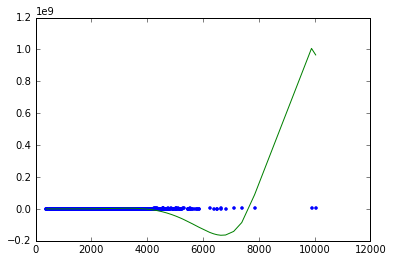

In [32]:
plt.plot(poly15_data_set_4['power_1'],poly15_data_set_4['price'],'.',
        poly15_data_set_4['power_1'], model15_set_4.predict(X15_set_4),'-')

These curves should vary a lot less, now that you applied a high degree of regularization.

# Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. **Cross-validation** seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called **k-fold cross-validation**. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
...<br>
Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that  all observations are used for both training and validation, as we iterate over segments of data. 

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. sklearn has a utility function for shuffling a given DataFrame. We reserve 10% of the data as the test set and shuffle the remainder.

In [33]:
(train_valid, test) = train_test_split(sales, test_size=0.1, train_size=0.9, random_state=1)
train_valid_shuffled = shuffle(train_valid, random_state=1)

In [35]:
def is_nan(x):
    return isinstance(x, float) and math.isnan(x)

In [104]:
def k_fold_cross_validation(k, l2_penalty, train_valid_shuffled, output_name, features_list, deg):
        
        poly_data = polynomial_dframe(train_valid_shuffled['sqft_living'],degree)
                
        feature_cols = poly_data.columns.tolist()
                
        poly_data['price'] = train_valid_shuffled['price']
                              
        num = len(poly_data)
        folds = KFold(num, n_folds=k, shuffle=False, random_state=None)
                
        mse = []
        
        for train_index, valid_index in folds:
            
            
            poly_data_train1 = poly_data.ix[train_index]
            poly_data_valid1 = poly_data.ix[valid_index]
            
            poly_data_train = poly_data_train1[poly_data_train1.power_1 > 0]
            poly_data_valid = poly_data_valid1[poly_data_valid1.power_1 > 0]
            
            X = poly_data_train[feature_cols]
            y = poly_data_train['price']
            
            model = Ridge(alpha=l2_penalty)
            model.fit(X,y)
            
            
            Xv = poly_data_valid[feature_cols]
            yv = poly_data_valid['price']
            prediction = model.predict(Xv)
        
            error = prediction - poly_data_valid['price']
            error_squared = error * error
        
            error_squared_sum = sum(error_squared)
                  
            mse.append(error_squared_sum)
            
        
        return np.mean(mse)

In [109]:
l2_penalty = 1e5

average_error = k_fold_cross_validation(10, l2_penalty, train_valid_shuffled, 'price', my_features, 15)
print average_error

3.46900890971e+20


Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Lets write a loop that does the following:
* We will again be aiming to fit a 15th-order polynomial model using the `sqft_living` input
* For `l2_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, you can use this Numpy function: `np.logspace(1, 7, num=13)`.)
    * Run 10-fold cross-validation with `l2_penalty`
* Check which L2 penalty produced the lowest average validation error.

print np.logspace(1,7,num=13)Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use `train_valid_shuffled` when generating polynomial features!

In [121]:
degree = 15

from array import *
errors = []
l2_penalties = []

for l2_penalty in np.logspace(1,7,num=13):
    average_error = k_fold_cross_validation(10, l2_penalty, train_valid_shuffled, 'price', my_features, 15)
    errors.append(average_error)
    l2_penalties.append(l2_penalty)

best_l2_penalty = 'NaN'
min_error = min(errors)
for i in xrange(len(result)):
    if errors[i] == min_error:
        best_l2_penalty = l2_penalties[i]
        print l2_penalties[i], errors[i]

10000000.0 3.4411303146e+20


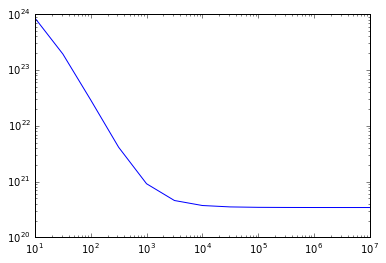

In [140]:
# Plot the l2_penalty values in the x axis and the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.
plt.xscale('log')
plt.yscale('log')
plt.plot(l2_penalties, errors,'-')

Once you found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of `l2_penalty`.  This way, your final model will be trained on the entire dataset.

In [129]:
degree = 15

poly_data_dframe = polynomial_dframe(train_valid_shuffled['sqft_living'],degree)

my_features = poly_data_dframe.columns.tolist()

X = poly_data_dframe[my_features]
poly_data_dframe['price'] = train_valid_shuffled['price']
y = poly_data_dframe['price']
            
model = Ridge(alpha=best_l2_penalty)
model.fit(X,y)

poly_data_dframe_test = polynomial_dframe(test['sqft_living'], degree)

Xt = poly_data_dframe_test[my_features]
predictions = model.predict(Xt)
error = predictions - test['price']
error_squared = error * error
error_squared_sum = sum(error_squared)
print error_squared_sum

3.80172512126e+19
